In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
import pathlib

# Replace 'local_path' with the local directory where you have downloaded and extracted the dataset.
local_path = "temp"
data_dir = pathlib.Path(local_path)

In [3]:
print(data_dir)

temp


In [4]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 766 files belonging to 5 classes.
Using 613 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 766 files belonging to 5 classes.
Using 153 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '5', 'free']


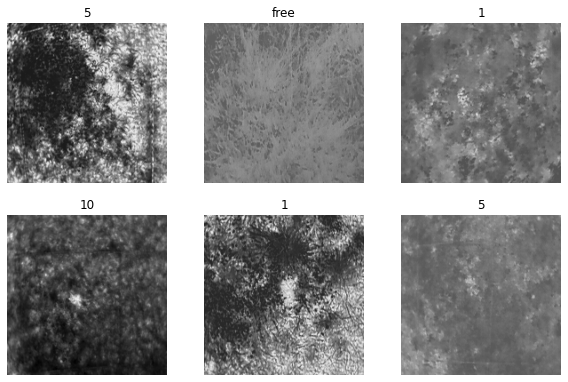

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
resnet_model = Sequential()

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')

for layer in pretrained_model.layers[:-2]:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(512, activation='sigmoid'))
resnet_model.add(Dense(5, activation='sigmoid'))

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrap  (None, 2048)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 1024)              2098176   
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 512)               524800    
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 5)                 2565      
 apper)                                                 

In [10]:
from keras.optimizers.legacy import Adam

# Define the learning rate
learning_rate = 0.001

# Create the optimizer with the desired learning rate
adam_optimizer = Adam(lr=learning_rate)
resnet_model.compile(optimizer=adam_optimizer, loss="sparse_categorical_crossentropy",metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:

epochs=20
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)


Epoch 1/20


20/20 [==============================] - 45s 2s/step - loss: 1.4478 - accuracy: 0.4225 - val_loss: 0.9894 - val_accuracy: 0.6536
Epoch 2/20
20/20 [==============================] - 39s 2s/step - loss: 1.0048 - accuracy: 0.5987 - val_loss: 0.8415 - val_accuracy: 0.6144
Epoch 3/20
20/20 [==============================] - 40s 2s/step - loss: 0.7720 - accuracy: 0.6966 - val_loss: 0.6589 - val_accuracy: 0.7647
Epoch 4/20
20/20 [==============================] - 38s 2s/step - loss: 0.6110 - accuracy: 0.7716 - val_loss: 0.9233 - val_accuracy: 0.6405
Epoch 5/20
20/20 [==============================] - 39s 2s/step - loss: 0.5901 - accuracy: 0.7977 - val_loss: 0.6105 - val_accuracy: 0.7451
Epoch 6/20
20/20 [==============================] - 38s 2s/step - loss: 0.4531 - accuracy: 0.8303 - val_loss: 0.6466 - val_accuracy: 0.8431
Epoch 7/20
20/20 [==============================] - 43s 2s/step - loss: 0.3223 - accuracy: 0.8956 - val_loss: 0.6870 - val_accuracy: 0.7190
Epoch 8/20
20/20 [=============

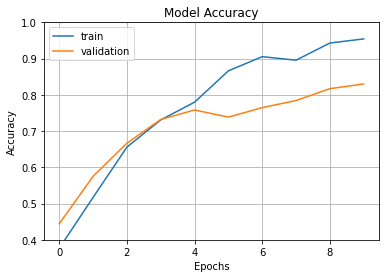

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

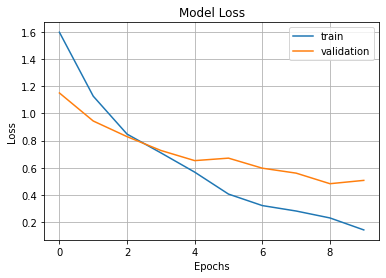

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

# Assuming class_names variable is defined as the list of class names

# Load the trained model (ensure to replace 'your_model.h5' with the actual path to your saved model)
model = tf.keras.models.load_model('resNet.h5')

# Assuming val_ds is your validation dataset
y_pred = []
y_true = []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Calculate the classification metrics
report = classification_report(y_true, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_true, y_pred)

print(report)
print(conf_matrix)
